In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [271]:
def dyn_gen(B):
    A = torch.tensor([[0,1.0,0],[0,0,1.0],[0,0,0]])
    B = torch.tensor(B) 
    
    def dynamics(x,u):
        return A @ x + B * u 
    
    return dynamics

dyn_vel = dyn_gen([[1.0],[0.0],[0.0]])
dyn_acc = dyn_gen([[0.0],[1.0],[0.0]])
dyn_jerk = dyn_gen([[0.0],[0.0],[1.0]])


def cost(x,u, sq_loss):
    pos = x[0]  #x if x.numel()==1 else x[0]
    target_cost = pos**2/10 if sq_loss else 1 - (-pos**2).exp()
    return target_cost + u**2     


def simulate(x0, u_all, dyn, iter_small):
    l = 0.0
    x = x0
    x_all = []
    x_all.append(x.detach().view(-1).numpy())
    for u in u_all:
        x = x + dyn(x, u)
        l = l + cost(x,u, sq_loss = iter_small)
        x_all.append(x.detach().view(-1).numpy())
    return l, x_all 


def optimize_u(x0, T, dyn, epoch, lr):
    l_all, u_all  = [], []
    x0 = torch.tensor([x0, 0.0, 0.0]).view(3,1) 
    u = torch.zeros(T, requires_grad=True)
    optim = torch.optim.SGD([u], lr=lr, momentum = 0.9)    #  optim = torch.optim.Adam([u], lr=lr)
    
    for iter_ in range(epoch):
        optim.zero_grad()
        l, x = simulate(x0, u, dyn, iter_<epoch/5)
        l.backward()
        optim.step()
        l_all.append(l.item())
        u_all.append(u.clone().detach().numpy())

    return l_all, x, u_all, u.detach()
    


In [274]:
def plot_all(l_all, u_opt, x_opt):
    plt.figure()
#     plt.subplot(1, 2, 1)

#     plt.semilogy(l_all)
#     plt.legend(['loss'])
    
#     plt.subplot(1, 2, 2)
    plt.plot(u_opt*-10)
    plt.plot(x_opt)
    plt.legend(['control', 'position', 'velocity', 'acceleration'])
    plt.show()


min speed


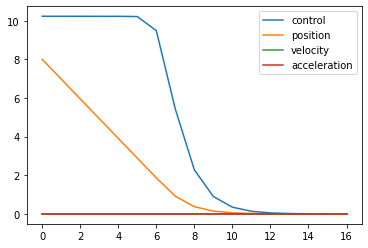

min acceleration


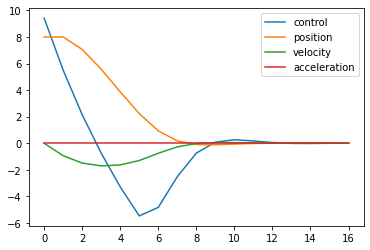

min jerk


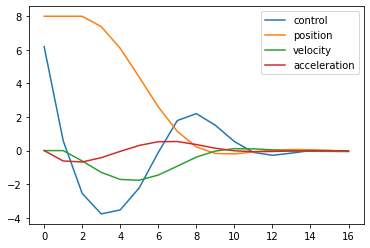

In [276]:

T= 16 #8
l_all, x_opt, u_all, u_opt = optimize_u(8.0, T, dyn_vel, epoch = 400, lr = 0.001)
print('min speed')
plot_all(l_all, u_opt, x_opt)
    
l_all, x_opt, u_all, u_opt = optimize_u(8.0, T, dyn_acc, epoch = 800, lr = 0.0001)
print('min acceleration')
plot_all(l_all, u_opt, x_opt)

l_all, x_opt, u_all, u_opt = optimize_u(8.0, T, dyn_jerk, epoch = 2000, lr = 0.000015)
print('min jerk')
plot_all(l_all, u_opt, x_opt)


In [285]:
def dyn_gen_clip(B, clip):
    A = torch.tensor([[0,1.0,0],[0,0,1.0],[0,0,0]])
    B = torch.tensor(B) 
    
    def dynamics(x,u):
        return A @ x + B * u.clamp(-clip, clip) 
    
    return dynamics

dyn_vel_clip = dyn_gen_clip([[1.0],[0.0],[0.0]], clip = 0.5)
dyn_acc_clip = dyn_gen_clip([[0.0],[1.0],[0.0]], clip = 0.3)
dyn_jerk_clip = dyn_gen_clip([[0.0],[0.0],[1.0]], clip = 0.2)


min speed - clipped


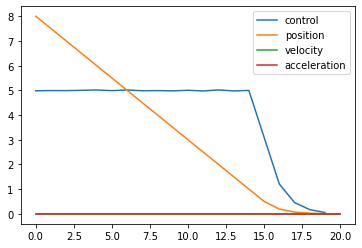

min acceleration - clipped


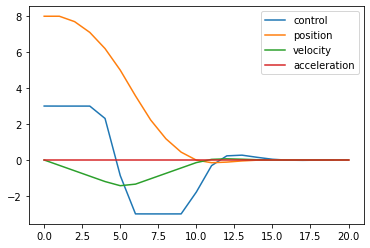

min jerk - clipped


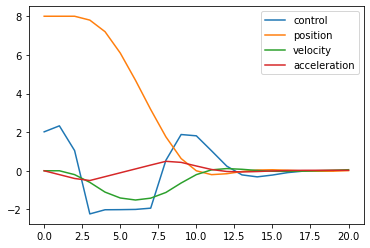

In [286]:

T= 20 #8
l_all, x_opt, u_all, u_opt = optimize_u(8.0, T, dyn_vel_clip, epoch = 400, lr = 0.001)
print('min speed - clipped')
plot_all(l_all, u_opt, x_opt)
    
l_all, x_opt, u_all, u_opt = optimize_u(8.0, T, dyn_acc_clip, epoch = 800, lr = 0.0001)
print('min acceleration - clipped')
plot_all(l_all, u_opt, x_opt)

l_all, x_opt, u_all, u_opt = optimize_u(8.0, T, dyn_jerk_clip, epoch = 2000, lr = 0.000015)
print('min jerk - clipped')
plot_all(l_all, u_opt, x_opt)
